# Ward 1: Pedestrian and Cyclist Crash Data

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

from sodapy import Socrata
from shapely.wkt import loads
from shapely.geometry import MultiPolygon, Point


## Read in data from the Chicago data portal

Traffic Crashes: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data

Traffic Crashes - People: https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data

Ward Maps: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Wards-2023-Map/cdf7-bgn3

You need to download a csv file to get the ward boundaries

In [2]:
# Establish connection with Chicago data portal
client = Socrata("data.cityofchicago.org", None)

In [3]:
# Get crash data

# Increase timeout counter because this takes a while
client.timeout = 300 # seconds

# Earliest date of crash data
start_date = '2020-01-01'

# Read in crashes
crash_df = pd.DataFrame.from_records(client.get("85ca-t3if", 
    where=f"crash_date > '{start_date}'",                                          
    limit=700000))
print(crash_df['crash_date'].min())
print(crash_df.shape)

2020-01-01T00:01:00.000
(522797, 48)


In [4]:
# Get crashes people data for pedestrians and cyclists
crash_people_df = pd.DataFrame.from_records(client.get("u6pd-qa9d", 
    where=f"crash_date > '{start_date}' and (person_type = 'PEDESTRIAN' or person_type='BICYCLE')",                                          
    limit=100000))
print(crash_people_df['crash_date'].min())

2020-01-01T00:40:00.000


In [5]:
# Merge the datasets on crash_id
crash_df = pd.merge(crash_df, crash_people_df, on='crash_record_id', 
    how='inner', suffixes=('_crash', '_people'))
crash_df

,crash_record_id,crash_date_crash,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,ejection,hospital,ems_agency,bac_result_value
0,c60bc35f99aef0ebe9cd7e48fd4dbf5bb97375b43b507b...,2024-11-29T15:55:00.000,35,PEDESTRIAN CROSSING SIGN,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,NOT OBSCURED,NORMAL,CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,NaN,NaN,NaN
1,17aca4e66df0b7775a778b27b71202cfe50e6c3fce664f...,2024-11-29T14:30:00.000,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,NOT OBSCURED,NORMAL,CROSSING - WITH SIGNAL,NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,NaN,NaN,NaN
2,db3ddf5193ebff3afa38272897a4a0cfd4189b6b9a6d6a...,2024-11-29T13:45:00.000,30,UNKNOWN,UNKNOWN,CLEAR,UNKNOWN,PEDALCYCLIST,UNKNOWN INTERSECTION TYPE,STRAIGHT AND LEVEL,...,NOT OBSCURED,NORMAL,WITH TRAFFIC,NO CONTRASTING CLOTHING,BIKE LANE,TEST NOT OFFERED,TOTALLY EJECTED,SAINT MARYS,NaN,NaN
3,903b8ee9c24d71f824661404f4776bb04d21c70f3678d2...,2024-11-29T12:48:00.000,45,NO CONTROLS,NO CONTROLS,SNOW,DAYLIGHT,PEDESTRIAN,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,UNKNOWN,NORMAL,OTHER ACTION,NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NaN,REFUSED,NaN,NaN
4,ff8e0f0964aa0b97bf17f7dca19cb89680371f68746435...,2024-11-28T22:00:00.000,40,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,ONE-WAY,STRAIGHT AND LEVEL,...,NOT OBSCURED,UNKNOWN,STANDING IN ROADWAY,NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NaN,MASONIC,CFD AMBO#61,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22677,65808deb465789ae9abb09e0cd4067dcf42686f82bf7d2...,2020-01-01T17:02:00.000,30,NO CONTROLS,NO CONTROLS,CLOUDY/OVERCAST,DUSK,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,UNKNOWN,IMPAIRED - ALCOHOL AND DRUGS,AGAINST TRAFFIC,NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NONE,NaN,CFD,NaN
22678,ffd327891afdf3b005974d1c4fa34892e3e3d8e538b904...,2020-01-01T12:13:00.000,30,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,ONE-WAY,STRAIGHT AND LEVEL,...,UNKNOWN,NORMAL,NO ACTION,CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NONE,NaN,NaN,NaN
22679,d71de23b13a212d025d56da9fe7605517007f2b7683e95...,2020-01-01T03:02:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,NOT OBSCURED,NORMAL,CROSSING - NO CONTROLS (AT INTERSECTION),NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NaN,NaN,CFD AMB 48,NaN
22680,05350d872f8bfe332d1b90006df77d743944f2c8b7309b...,2020-01-01T03:00:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,UNKNOWN,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,ONE-WAY,STRAIGHT AND LEVEL,...,UNKNOWN,UNKNOWN,CROSSING - WITH SIGNAL,NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,ST. BERNARD,NaN,NaN


## Limit data to crashes within Ward 1

In [6]:
# Read in the ward boundaries
ward_boundaries = pd.read_csv('Boundaries_-_Wards__2023-__20241119.csv')
ward_boundaries.head(5)

,Ward,the_geom,objectid,edit_date,ward_id,globalid,st_area_sh,st_length_
0,1,MULTIPOLYGON (((-87.68777205374418 41.92858465...,51,06/01/2022,1,{DB2A2A7D-FAF1-42A4-B061-AE18C31A80BB},6.589346e+07,61878.821587
1,2,MULTIPOLYGON (((-87.62517201063106 41.90399836...,52,06/01/2022,2,{88F300F6-D6DF-4337-8DE3-0C2D27A5B338},3.128511e+07,74175.949239
2,5,MULTIPOLYGON (((-87.56030308695986 41.76635735...,55,06/01/2022,5,{0A109A41-9DED-47D7-934E-1EA1CC7EE025},1.120803e+08,88207.690241
3,6,MULTIPOLYGON (((-87.61794321281114 41.77292489...,56,06/01/2022,6,{FD74A999-4BBA-4CE3-BEBB-CC76423037E8},1.392022e+08,80779.851890
4,7,MULTIPOLYGON (((-87.54393108740227 41.76029599...,57,06/01/2022,7,{279FCBD9-EA0D-4FFC-A8CA-EDA2676C0721},1.414924e+08,98906.567862


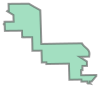

In [7]:
# Get the Ward 1 boundaries
ward1 = loads(ward_boundaries.loc[ward_boundaries['Ward'] == 1, 'the_geom'].iloc[0])
ward1


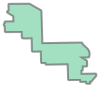

In [8]:
# Add a slight buffer to the ward boundaries to include points on the edge
ward1 = ward1.buffer(0.0005)
ward1

In [9]:
# Determine if a latitude and longitude are within the ward
crash_df_geo = gpd.GeoDataFrame(crash_df, 
    geometry=gpd.points_from_xy(crash_df['longitude'], crash_df['latitude']), 
    crs="EPSG:4326"
)
crash_df_geo['in_ward1'] = crash_df_geo.geometry.apply(lambda x: ward1.contains(x))

crash_df_geo['in_ward1'].value_counts()


/Users/eachase/miniconda3/envs/py312/lib/python3.12/site-packages/shapely/predicates.py:526: RuntimeWarning: invalid value encountered in contains
  return lib.contains(a, b, **kwargs)


in_ward1
False    21836
True       846
Name: count, dtype: int64

In [10]:
# Limit dataframe to crashes within the ward
ward1_crashes = crash_df_geo.loc[crash_df_geo['in_ward1']]
ward1_crashes


,crash_record_id,crash_date_crash,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,ejection,hospital,ems_agency,bac_result_value,geometry,in_ward1
2,db3ddf5193ebff3afa38272897a4a0cfd4189b6b9a6d6a...,2024-11-29T13:45:00.000,30,UNKNOWN,UNKNOWN,CLEAR,UNKNOWN,PEDALCYCLIST,UNKNOWN INTERSECTION TYPE,STRAIGHT AND LEVEL,...,WITH TRAFFIC,NO CONTRASTING CLOTHING,BIKE LANE,TEST NOT OFFERED,TOTALLY EJECTED,SAINT MARYS,NaN,NaN,POINT (-87.67667 41.89967),True
19,24169ba8a892ed76f31dd9ca16cbf0a32520bd0165ce57...,2024-11-27T15:10:00.000,30,PEDESTRIAN CROSSING SIGN,FUNCTIONING PROPERLY,CLOUDY/OVERCAST,DAYLIGHT,PEDESTRIAN,FOUR WAY,STRAIGHT ON GRADE,...,CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,DNA,CFD AMBO 3,NaN,POINT (-87.69030 41.92677),True
42,7b679441a99b0656948c8437f2448c59a1a039c22ed965...,2024-11-25T17:35:00.000,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,...,AGAINST TRAFFIC,NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,UNKNOWN,NORTHWESTERN,CFD 62,NaN,POINT (-87.66718 41.89505),True
63,e6920224a5eb97523d066329f5f61c02b679202daba4ac...,2024-11-23T00:25:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLOUDY/OVERCAST,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,...,CROSSING - WITH SIGNAL,NO CONTRASTING CLOTHING,BIKE LANE,TEST NOT OFFERED,TOTALLY EJECTED,ST. MARY'S,3,NaN,POINT (-87.70023 41.92482),True
78,f676f3859e18020bd9fa0835b42d175bb07b35ba13e35f...,2024-11-21T20:17:00.000,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,WITH TRAFFIC,NO CONTRASTING CLOTHING,BIKEWAY,TEST NOT OFFERED,UNKNOWN,NaN,NaN,NaN,POINT (-87.66587 41.90282),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22570,2d3d8afbfef12505c531cca7685bdfe8371f25eb75285f...,2020-01-11T11:45:00.000,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,WITH TRAFFIC,NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NONE,STROGER HOSPITAL,53,NaN,POINT (-87.66079 41.88894),True
22610,c55107174e05837de51bd3ecc6b6a1d85d97b4d6cf9a9e...,2020-01-09T11:40:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,NaN,NaN,NaN,NaN,NaN,POINT (-87.68241 41.91050),True
22616,08d035d2c95c34c0552196e609d05e777306563e8cd3ed...,2020-01-08T17:33:00.000,25,PEDESTRIAN CROSSING SIGN,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,FOUR WAY,STRAIGHT AND LEVEL,...,CROSSING - NO CONTROLS (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,SAINT MARYS,CFD #30,NaN,POINT (-87.67496 41.90313),True
22629,b6cd3a7f3d8d72bd77eb5e1cec5229b9d05337cb74873c...,2020-01-07T16:30:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,DUSK,PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,WITH TRAFFIC,NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NONE,REFUSED,NaN,NaN,POINT (-87.67647 41.90960),True


# Export data
Clean a bit before exporting

In [11]:
ward1_crashes.columns

Index(['crash_record_id', 'crash_date_crash', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'hit_and_run_i', 'damage', 'date_police_notified',
       'prim_contributory_cause', 'sec_contributory_cause', 'street_no',
       'street_direction', 'street_name', 'beat_of_occurrence', 'num_units',
       'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown', 'crash_hour', 'crash_day_of_week', 'crash_month',
       'latitude', 'longitude', 'location', 'intersection_related_i',
       'crash_date_est_i', 'statements_taken_i', 'photos_taken_i',
       'private_property_i', 'work_zone_i', 'work_zone_type', 'dooring_i',
       'w

In [12]:
ward1_crashes

,crash_record_id,crash_date_crash,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,ejection,hospital,ems_agency,bac_result_value,geometry,in_ward1
2,db3ddf5193ebff3afa38272897a4a0cfd4189b6b9a6d6a...,2024-11-29T13:45:00.000,30,UNKNOWN,UNKNOWN,CLEAR,UNKNOWN,PEDALCYCLIST,UNKNOWN INTERSECTION TYPE,STRAIGHT AND LEVEL,...,WITH TRAFFIC,NO CONTRASTING CLOTHING,BIKE LANE,TEST NOT OFFERED,TOTALLY EJECTED,SAINT MARYS,NaN,NaN,POINT (-87.67667 41.89967),True
19,24169ba8a892ed76f31dd9ca16cbf0a32520bd0165ce57...,2024-11-27T15:10:00.000,30,PEDESTRIAN CROSSING SIGN,FUNCTIONING PROPERLY,CLOUDY/OVERCAST,DAYLIGHT,PEDESTRIAN,FOUR WAY,STRAIGHT ON GRADE,...,CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,DNA,CFD AMBO 3,NaN,POINT (-87.69030 41.92677),True
42,7b679441a99b0656948c8437f2448c59a1a039c22ed965...,2024-11-25T17:35:00.000,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,...,AGAINST TRAFFIC,NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,UNKNOWN,NORTHWESTERN,CFD 62,NaN,POINT (-87.66718 41.89505),True
63,e6920224a5eb97523d066329f5f61c02b679202daba4ac...,2024-11-23T00:25:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLOUDY/OVERCAST,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,...,CROSSING - WITH SIGNAL,NO CONTRASTING CLOTHING,BIKE LANE,TEST NOT OFFERED,TOTALLY EJECTED,ST. MARY'S,3,NaN,POINT (-87.70023 41.92482),True
78,f676f3859e18020bd9fa0835b42d175bb07b35ba13e35f...,2024-11-21T20:17:00.000,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,WITH TRAFFIC,NO CONTRASTING CLOTHING,BIKEWAY,TEST NOT OFFERED,UNKNOWN,NaN,NaN,NaN,POINT (-87.66587 41.90282),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22570,2d3d8afbfef12505c531cca7685bdfe8371f25eb75285f...,2020-01-11T11:45:00.000,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,WITH TRAFFIC,NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NONE,STROGER HOSPITAL,53,NaN,POINT (-87.66079 41.88894),True
22610,c55107174e05837de51bd3ecc6b6a1d85d97b4d6cf9a9e...,2020-01-09T11:40:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,NaN,NaN,NaN,NaN,NaN,POINT (-87.68241 41.91050),True
22616,08d035d2c95c34c0552196e609d05e777306563e8cd3ed...,2020-01-08T17:33:00.000,25,PEDESTRIAN CROSSING SIGN,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,FOUR WAY,STRAIGHT AND LEVEL,...,CROSSING - NO CONTROLS (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,SAINT MARYS,CFD #30,NaN,POINT (-87.67496 41.90313),True
22629,b6cd3a7f3d8d72bd77eb5e1cec5229b9d05337cb74873c...,2020-01-07T16:30:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,DUSK,PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,WITH TRAFFIC,NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NONE,REFUSED,NaN,NaN,POINT (-87.67647 41.90960),True


In [13]:
# Decide which columns to export
df_export = ward1_crashes[[
    'crash_date_crash',
    'person_type', 
    'street_no',
    'street_direction',
    'street_name',
    'latitude',
    'longitude',
    'posted_speed_limit',
    'driver_action',    
    'injury_classification',
    'driver_vision',
    'pedpedal_action',
    'pedpedal_location',
    'first_crash_type',
]]

# Rename some columns
df_export = df_export.rename(columns={'crash_date_crash': 'crash_date_time'})

# Reset indices
df_export = df_export.reset_index(drop=True)
df_export

,crash_date_time,person_type,street_no,street_direction,street_name,latitude,longitude,posted_speed_limit,driver_action,injury_classification,driver_vision,pedpedal_action,pedpedal_location,first_crash_type
0,2024-11-29T13:45:00.000,BICYCLE,1948,W,AUGUSTA BLVD,41.899668721,-87.676674049,30,NONE,NONINCAPACITATING INJURY,NOT OBSCURED,WITH TRAFFIC,BIKE LANE,PEDALCYCLIST
1,2024-11-27T15:10:00.000,PEDESTRIAN,2500,N,CAMPBELL AVE,41.926769624,-87.690300272,30,NONE,"REPORTED, NOT EVIDENT",NOT OBSCURED,CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION),IN CROSSWALK,PEDESTRIAN
2,2024-11-25T17:35:00.000,BICYCLE,1599,W,SUPERIOR ST,41.89504789,-87.667181273,35,UNKNOWN,INCAPACITATING INJURY,NOT OBSCURED,AGAINST TRAFFIC,IN CROSSWALK,PEDALCYCLIST
3,2024-11-23T00:25:00.000,BICYCLE,2393,N,MILWAUKEE AVE,41.924816741,-87.700234498,30,NONE,"REPORTED, NOT EVIDENT",UNKNOWN,CROSSING - WITH SIGNAL,BIKE LANE,PEDALCYCLIST
4,2024-11-21T20:17:00.000,BICYCLE,1164,N,MILWAUKEE AVE,41.90282089,-87.665870353,30,NONE,NONINCAPACITATING INJURY,UNKNOWN,WITH TRAFFIC,BIKEWAY,PEDALCYCLIST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,2020-01-11T11:45:00.000,BICYCLE,400,N,OGDEN AVE,41.888940099,-87.660787607,30,OTHER,"REPORTED, NOT EVIDENT",NOT OBSCURED,WITH TRAFFIC,IN ROADWAY,PEDALCYCLIST
842,2020-01-09T11:40:00.000,PEDESTRIAN,2200,W,NORTH AVE,41.910502517,-87.682409763,30,NaN,NONINCAPACITATING INJURY,NaN,CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION),IN CROSSWALK,PEDESTRIAN
843,2020-01-08T17:33:00.000,PEDESTRIAN,1154,N,WOLCOTT AVE,41.903128146,-87.674964283,25,NONE,NONINCAPACITATING INJURY,OTHER,CROSSING - NO CONTROLS (NOT AT INTERSECTION),IN CROSSWALK,PEDESTRIAN
844,2020-01-07T16:30:00.000,BICYCLE,1550,N,MILWAUKEE AVE,41.90959687,-87.676471511,30,NONE,NONINCAPACITATING INJURY,NOT OBSCURED,WITH TRAFFIC,IN ROADWAY,PEDALCYCLIST


In [14]:
# Export file
df_export.to_csv(f'ward1_crashes_since_{start_date}.csv', index=False)